# Setup

In [1]:
# import json
import os
from glob import glob
from pathlib import Path
# import random

# import cv2
# import earthpy as et
import earthpy.plot as ep # for plotting
import geopandas as gpd # to read shapefile (vector label)
import GeoPatch # to make patches from the raster mask
import matplotlib.pyplot as plt # for plotting
import numpy as np # for rasterization process
import rasterio as rio # to open raster
import rioxarray as rx # to open raster
from rasterio.features import geometry_mask # for rasterization process
from rasterio.plot import plotting_extent, show # for plotting
from tqdm.auto import tqdm # misc

import data_prep # custom function

# import earthpy.spatial as es

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ROOT_DIR = Path(os.getcwd())

DATA_DIR = ROOT_DIR / 'data'

In [4]:
raster_path = DATA_DIR / 'arvena_clip.tif' # the path to your imagery (raster)
shp_path = DATA_DIR / 'training_label_arvena_0.shp' # the path to your vector label (shapefile)
mask_path = DATA_DIR / str(shp_path.name.split('.')[0] + '_mask.tif') # where would you like to save the mask later

# Importing Raster and Vector

Also make sure the CRS are aligned

In [5]:
training_label = gpd.read_file(shp_path)
training_label.head()

,Shape_Leng,Shape_Area,geometry
0,18.931028,28.519278,"POLYGON ((865149.410 9914210.799, 865149.833 9..."
1,17.159965,23.432733,"POLYGON ((865146.620 9914218.297, 865147.017 9..."
2,18.384168,26.895405,"POLYGON ((865153.552 9914220.259, 865153.951 9..."
3,15.881643,20.071554,"POLYGON ((865155.339 9914211.758, 865155.689 9..."
4,18.625395,27.605849,"POLYGON ((865160.134 9914204.653, 865160.567 9..."


In [6]:
raster_rx = rx.open_rasterio(raster_path, masked=True)
raster_rx

<xarray.DataArray (band: 4, y: 3407, x: 11135)> Size: 607MB
[151747780 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 89kB 8.651e+05 8.651e+05 ... 8.66e+05 8.66e+05
  * y            (y) float64 27kB 9.914e+06 9.914e+06 ... 9.914e+06 9.914e+06
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  6097.035259095273,4982.700399874509,4680.3151031...
    STATISTICS_MAXIMUM:      255
    STATISTICS_MEAN:         150.23907953049
    ...                      ...
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       78.083514643587
    scale_factor:            1.0
    add_offset:              0.0

In [7]:
print("Checking raster and vector Coordinate Reference System (CRS)...")

if training_label.crs.to_epsg() != training_label.crs.to_epsg():
    raise ValueError(
        f"""
        Raster CRS ({raster_rx.rio.crs.to_epsg()}) != vector CRS ({training_label.crs.to_epsg()}).
        """
    )
else:
    print("CRS are aligned, good to go!")


Checking raster and vector Coordinate Reference System (CRS)...
CRS are aligned, good to go!


## Checking Raster and Vector

Make sure the raster and vector are aligned

<Axes: title={'center': 'RGB Composite image'}>

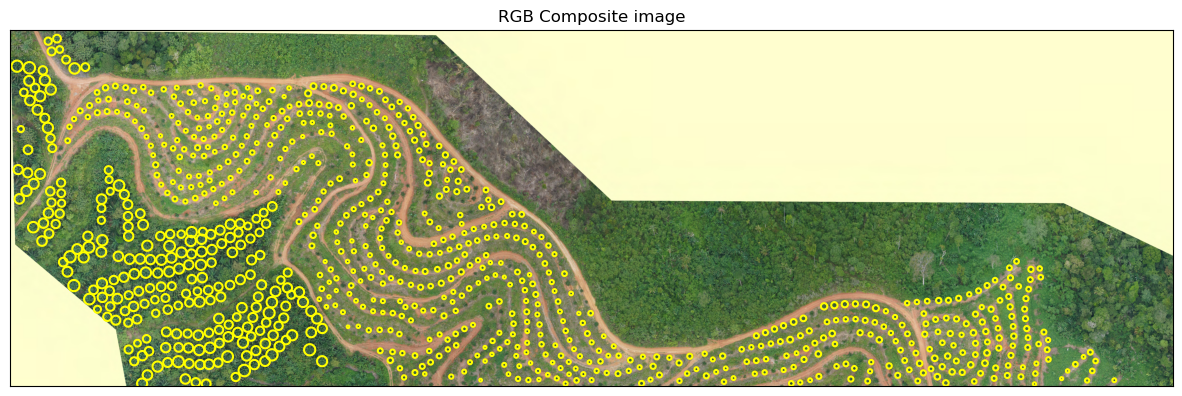

In [9]:
fig, ax = plt.subplots(figsize = (15,6))

# Creating the plot extent object
raster_plot_extent = plotting_extent(
    raster_rx[0],
    raster_rx.rio.transform()
)

ep.plot_rgb(
    raster_rx.values,
    rgb=[0, 1, 2],
    title="RGB Composite image",
    extent=raster_plot_extent,
    ax=ax
)

training_label.boundary.plot(
    color='yellow',
    ax=ax
)


# Convert Vector to Raster

Convert training label from shapefile (vector) to mask (raster)

In [10]:
with rio.open(raster_path) as src:
    # Reproject the shapefile to match the raster's CRS
    training_label = training_label.to_crs(src.crs)

    # Get the geometry of the shapefile
    geometry = training_label.geometry

    # Create a mask using the geometry and raster's shape
    mask = geometry_mask(geometry, out_shape=src.shape, transform=src.transform, invert=True)

    # Assign a specified label value to the areas within the shapefile
    label_value = (255, 255, 255)  # RGB value for the label
    mask_rgb = np.zeros((src.height, src.width, 3), dtype=np.uint8)
    mask_rgb[mask] = label_value

    # Transpose the mask_rgb array
    mask_rgb = np.transpose(mask_rgb, (2, 0, 1))

## Save the rasterized label to the specified folder

In [11]:
# Save the mask as a raster
if not os.path.exists(mask_path):
    print(f"Saving rasterized label to {mask_path}")
    with rio.open(
        mask_path, 'w', driver='GTiff', width=src.width, height=src.height,
        count=3, crs=src.crs, transform=src.transform, dtype=rio.uint8
        ) as dst:
        dst.write(mask_rgb)
else:
    print(f"{mask_path} already exists, skipping the process")

Saving rasterized label to /home/amrirasyidi/projects/sawit_counting/data/training_label_arvena_0_mask.tif


## Checking Imagery and Mask

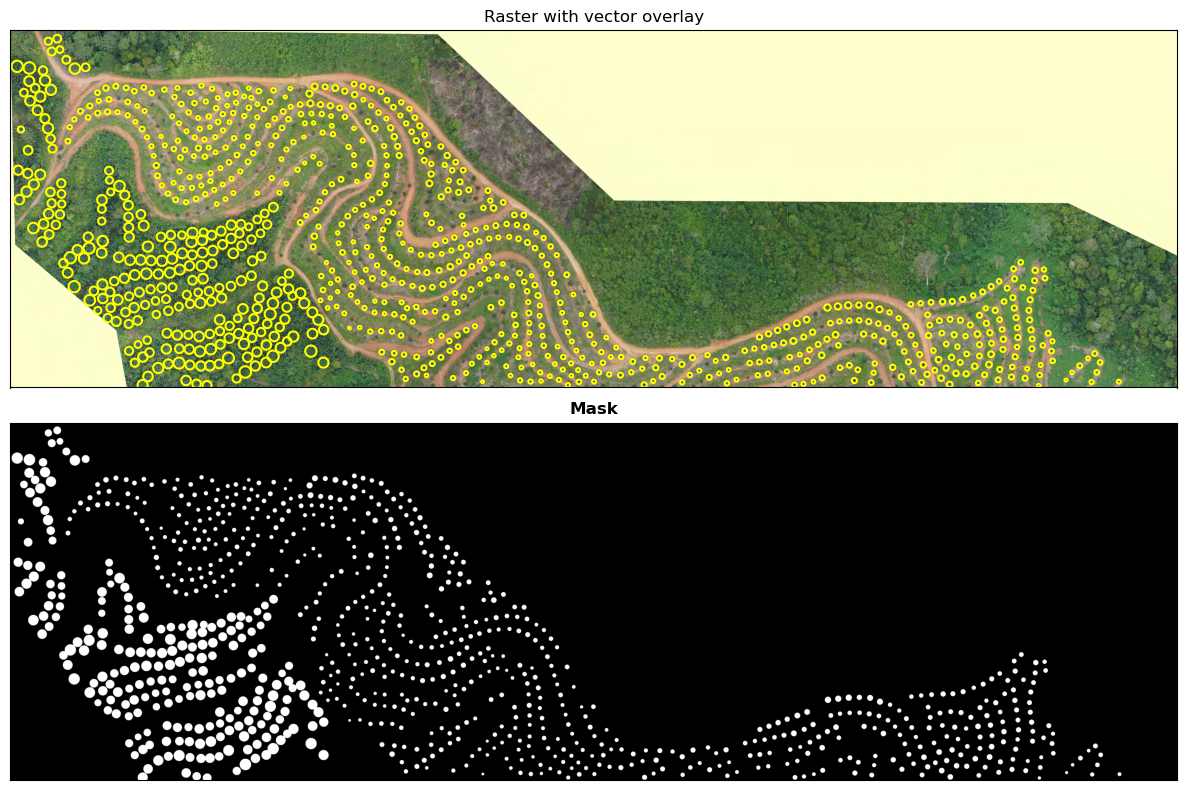

In [12]:
fig, ax = plt.subplots(2,1,figsize=(14,8))

ep.plot_rgb(
    raster_rx.values,
    rgb=[0, 1, 2],
    title="Raster with vector overlay",
    extent=raster_plot_extent,
    ax=ax[0]
)

training_label.boundary.plot(
    color='yellow',
    ax=ax[0]
)

with rio.open(mask_path) as mask:
    show(
        mask,
        title="Mask",
        ax=ax[1]
    )

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

# Convert mask into patches

In [13]:
# setup patch size and stride length
patch_sz = 512
stride_dist = 256

In [14]:
# initiate TrainPatch object to be later patched 
patch = GeoPatch.TrainPatch(
    image=str(raster_path), label=str(mask_path),
    patch_size=patch_sz, stride=stride_dist, channel_first=True
)

In [15]:
# Displaying shape and size of input image
patch.data_dimension()

# Displaying the number of orginal image patches
patch.patch_info()

############################################
 the shape of image is: (4, 3407, 11135) 
 the shape of label is: (3407, 11135) 
############################################
       
#######################################################################################
The effective X-dimension of the input data for patch generation is from 0 to 3328
The effective Y-dimension of the input data for patch generation is from 0 to 11008
The number of total non-augmented patches that can be generated
based on patch size (512*512) and stride (256) is "451"
#######################################################################################
                                                                        


In [17]:
# Saving image as Geotiff file
image_patch_dir = ROOT_DIR / "test_patch"
if not os.path.exists(image_patch_dir):
    patch.save_Geotif(str(image_patch_dir), only_label=True)
else:
    print(f"Patch already exists in: {image_patch_dir}")

Patch Counter:   0%|          | 0/451 [00:00<?, ? Patch/s]

Patch Counter:  53%|█████▎    | 239/451 [00:01<00:01, 143.22 Patch/s]

#######################################################################################
239 patches, which are %52 of totall patches, are saved as ".tif" format in "/home/amrirasyidi/projects/sawit_counting\/home/amrirasyidi/projects/sawit_counting/test_patch"
#######################################################################################


# Convert mask into json

In [64]:
mask_patch_path = sorted(glob(str(image_patch_dir / 'label' / '*.tif')))
image_patch_path = sorted(glob(str(image_patch_dir / 'patch' / '*.tif')))
label = "palm_tree"

for mask, image in tqdm(zip(mask_patch_path, image_patch_path), total=len(mask_patch_path)):
    # print(f"========{image}========")
    # data_prep.mask_to_geojson(mask, image, label, geo=False)
    
    if not os.path.exists(image.replace('.tif','.json')):
        print("converting mask to json...")
        data_prep.mask_to_geojson(mask, image, label, geo=False)
    else:
        print("masks already exist, skipping the process...")

  0%|          | 0/239 [00:00<?, ?it/s]

### Check reverse compatibility

In [65]:
sample_no = str(100)

                                            geometry      label
0  POLYGON ((511.000 493.000, 509.000 495.000, 50...  palm_tree
1  POLYGON ((0.000 491.000, 0.000 511.000, 28.000...  palm_tree
2  POLYGON ((110.000 425.000, 109.000 426.000, 10...  palm_tree
3  POLYGON ((0.000 399.000, 0.000 474.000, 2.000 ...  palm_tree
4  POLYGON ((362.000 391.000, 361.000 392.000, 35...  palm_tree


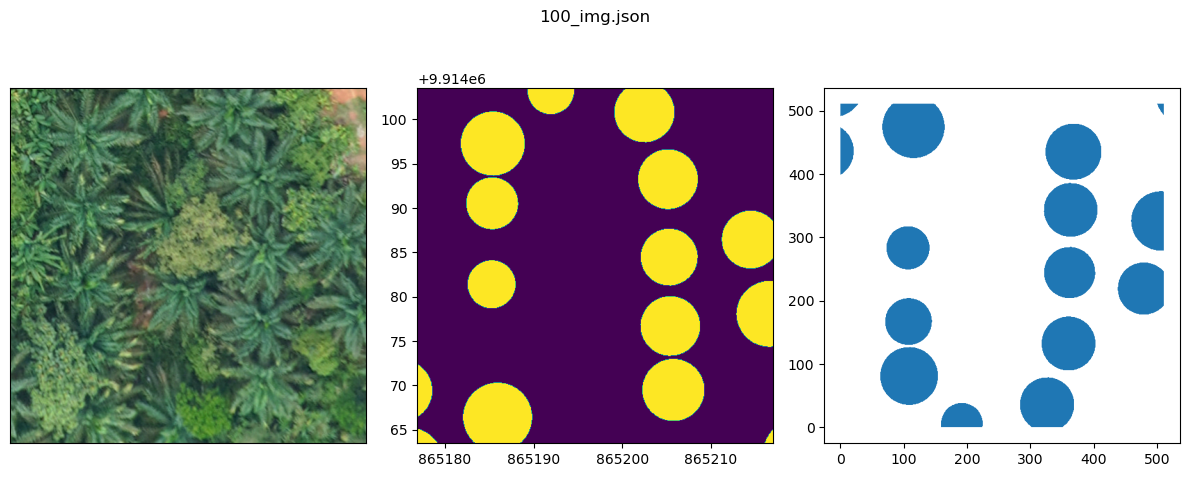

In [67]:
image_file_path = image_patch_dir / 'patch' / (sample_no+'_img.tif')
_image = rx.open_rasterio(image_file_path, masked=True)

mask_file_path = image_patch_dir / 'label' / (sample_no+'_lbl.tif')

json_file_path = image_patch_dir / 'patch' / (sample_no+'_img.json')
# json_file_path = 'test.json'
gdf_mask = data_prep.json_to_geodataframe(json_file_path)
print(gdf_mask.head())

fig, ax = plt.subplots(1,3, figsize = (12,5))

# Creating the plot extent object
_plot_extent = plotting_extent(
    _image[0],
    _image.rio.transform()
)

ep.plot_rgb(
    _image.values,
    rgb=[0, 1, 2],
    # title="Raster with vector overlay",
    extent=_plot_extent,
    ax=ax[0]
)
with rio.open(mask_file_path) as mask:
    show(
        mask,
        # title="Mask",
        ax=ax[1]
    )
gdf_mask.plot(ax=ax[2])

plt.suptitle(f'{Path(json_file_path).name}')
plt.tight_layout()

You may notice the json mask file is flipped vertically, this is normal since later we will use cv2 library which reads the image from top left, i.e. the origin (0,0) point will be on top left.

In [71]:
num_patch=4

patch.visualize(
    folder_name=image_patch_dir,
    patches_to_show=num_patch,
    band_num=1,
    fig_size=(6, num_patch*3),
    dpi=96
)

plt.tight_layout()

image and label for the following patches will be displayed are: 


<Figure size 640x480 with 0 Axes>

# Split Folder

# Placeholder

In [ ]:
# def visualize(folder_name="npy",patches_to_show=1, band_to_show=[0, 1, 2], fig_size=(10,20), dpi=96):
#         """
#         Using this function generated patches can be displayed
        
#         parameters:
#         -----------
#         folder_name:        String
#                             The folder name that passed for saving patches should be passed here 
#                             to retrieve patches and display. 
        
#         patches_to_show:    Integer
#                             Number of random patches to display.
                            
#         band_num:           Integer
#                             the image band to be displayed.
#                             to display the last band number just pass 0 and for the first band 1.
                            
#         figsize:            Tuple 
#                             plotting size for patches, the default is (10,20).
                            
#         dpi:                Integer
#                             Dots per inches (dpi) to determine the size of the figure in inches, the default value is 96.
#         """

#         print('image and label for the following patches will be displayed are: ')
#         patch_dir=sorted(glob.glob(os.path.join(os.getcwd(),folder_name, "patch/*")))
#         label_dir=sorted(glob.glob(os.path.join(os.getcwd(),folder_name, "label/*")))

#         idx=np.random.randint(1, len(patch_dir), patches_to_show)
#         if patch_dir[0][-3:]=="tif":
#             fig,ax= plt.subplots(len(idx),2, figsize=fig_size, dpi=dpi)
#             for i in range(len(idx)):
#                 file=patch_dir[idx[i]]
#                 print(file)
#                 file_=label_dir[idx[i]]
#                 print(file_)
#                 img_=rio.open(file)
#                 img=img_.read()
#                 lbl=rio.open(file_)
#                 lbl=lbl.read(1)
#                 # Creating the plot extent object
#                 raster_plot_extent = plotting_extent(
#                     img_,
#                 )
#                 if patches_to_show<2:
#                     # ax[i].imshow(img[band_num,:,:])
#                     ep.plot_rgb(
#                         img,
#                         rgb=band_to_show,
#                         extent=raster_plot_extent,
#                         ax=ax[i]
#                     )
#                     ax[i+1].imshow(lbl)
#                 else:
#                     # ax[i,0].imshow(img[band_num,:,:])
#                     ep.plot_rgb(
#                         img,
#                         rgb=band_to_show,
#                         extent=raster_plot_extent,
#                         ax=ax[i,0]
#                     )
#                     ax[i,1].imshow(lbl)
                    
#         if patch_dir[0][-3:]=="npy":
#             fig,ax= plt.subplots(len(idx),2, figsize=fig_size, dpi=dpi)
#             for i in range(len(idx)):
#                 file=patch_dir[idx[i]]
#                 print(file)
#                 file_=label_dir[idx[i]]
#                 print(file_)
#                 img=np.load(file)
#                 lbl=np.load(file_)
#                 if patches_to_show<2:
#                     ax[i].imshow(img[:,:,band_num])
#                     ax[i+1].imshow(lbl)
#                 else:
#                     ax[i,0].imshow(img[:,:,band_num])
#                     ax[i,1].imshow(lbl)

image and label for the following patches will be displayed are: 
/home/amrirasyidi/projects/sawit_counting/test_patch/patch/168_img.tif
/home/amrirasyidi/projects/sawit_counting/test_patch/label/168_lbl.tif
/home/amrirasyidi/projects/sawit_counting/test_patch/patch/168_img.tif
/home/amrirasyidi/projects/sawit_counting/test_patch/label/168_lbl.tif


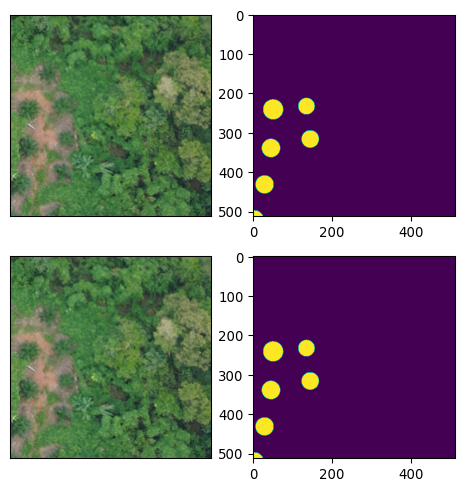

In [ ]:
# num_patch = 2
# visualize(folder_name='test_patch',patches_to_show=num_patch,
# fig_size=(6, num_patch*3),dpi=96)

In [ ]:
_ = rx.open_rasterio("/home/amrirasyidi/projects/sawit_counting/test_patch/patch/100_img.tif", masked=True)
_

<xarray.DataArray (band: 4, y: 512, x: 512)> Size: 4MB
[1048576 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 4kB 8.652e+05 8.652e+05 ... 8.652e+05 8.652e+05
  * y            (y) float64 4kB 9.914e+06 9.914e+06 ... 9.914e+06 9.914e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

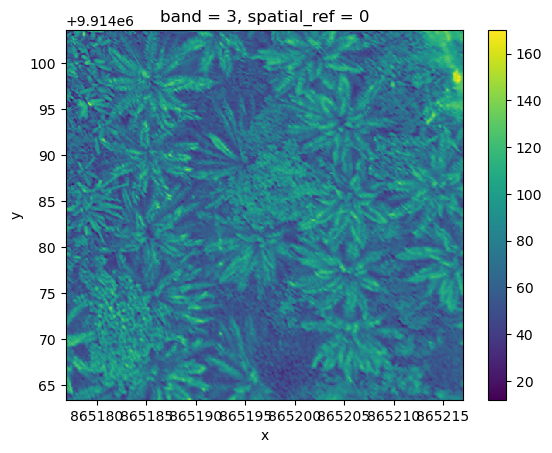

In [ ]:
_[2].plot()

In [ ]:
np.array(_)

array([[[108., 101.,  77., ..., 196., 199., 202.],
        [ 93.,  91.,  76., ..., 186., 188., 191.],
        [ 56.,  49.,  51., ..., 182., 180., 182.],
        ...,
        [ 54.,  47.,  45., ...,  78.,  78.,  79.],
        [ 49.,  42.,  46., ...,  78.,  78.,  76.],
        [ 53.,  45.,  49., ...,  79.,  76.,  75.]],

       [[141., 130., 102., ..., 152., 156., 157.],
        [123., 120., 103., ..., 145., 149., 151.],
        [ 86.,  78.,  82., ..., 142., 145., 145.],
        ...,
        [ 92.,  81.,  78., ..., 107., 107., 107.],
        [ 89.,  76.,  77., ..., 107., 106., 104.],
        [ 93.,  82.,  82., ..., 107., 104., 103.]],

       [[ 82.,  82.,  64., ..., 119., 121., 123.],
        [ 65.,  71.,  63., ..., 111., 113., 115.],
        [ 30.,  29.,  38., ..., 108., 109., 110.],
        ...,
        [ 64.,  57.,  55., ...,  80.,  80.,  80.],
        [ 58.,  52.,  57., ...,  78.,  79.,  79.],
        [ 64.,  58.,  61., ...,  78.,  77.,  76.]],

       [[255., 255., 255., ..., 255.,